In [1]:
from pandas import Series, DataFrame
import pandas as pd
import calendar
import matplotlib
matplotlib.rcParams.update({'figure.autolayout': True})
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

Populating the interactive namespace from numpy and matplotlib


# Setup

In [2]:
#read data in, appended 2014/2015, removed GO from col names
crime2014 = pd.read_csv("https://raw.githubusercontent.com/sxzhu/mis381_project/master/Austin_Crime_2014.csv", dtype=unicode, encoding='utf-8')
crime2014[:3]

crime2015 = pd.read_csv("https://raw.githubusercontent.com/sxzhu/mis381_project/master/Austin_Crime_2015.csv", dtype=unicode, encoding='utf-8')
crime = crime2014.append(crime2015,ignore_index=True)

crime = crime.rename(index=str, columns={"Highest NIBRS/UCR Offense Description": "General Offense Description",\
                                 "GO Highest Offense Desc":"Detailed Offense Description",\
                                 "GO Location":"Location","GO Report Date":"Report Date",\
                                 "GO Location Zip":"Zipcode","GO District":"District","GO Census Tract":"Census Tract",\
                                 "GO X Coordinate":"X Coordinate","GO Y Coordinate":"Y Coordinate",\
                                      "GO Primary Key":"Primary Key"})

crime = crime.drop('Location_1', axis=1)
crime['Date'] = pd.DatetimeIndex(crime['Report Date'])
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Month'] = crime['Month'].apply(lambda x: calendar.month_abbr[x])
crime['Year'] = pd.DatetimeIndex(crime['Report Date']).year

## Merge Crimes

In [3]:
def merge_crimes(s):
    """Map some crimes together."""
    
    # Create a map of misspellings to correct spelling
    misspellings = {'Burglary / \nBreaking & Entering':'Burglary',
                    'Auto Theft':'Theft: Auto Parts',
                    'Homicide: Murder & Nonnegligent Manslaughter':'Murder',
                    'Agg Assault':'Aggravated Assault'}
    
    if s in misspellings:
        return misspellings[s]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_crimes)

def merge_theft(s):
    """Map some crimes together."""
    
    if (s[:5]=='Theft'):
        return s[:5]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_theft)

# Check that it worked
# mask = (crime['General Offense Description'] == 'Agg Assault')
# crime['General Offense Description'][mask]  # should be empty

crime['General Offense Description'].value_counts()

Theft                 61908
Burglary              10597
Aggravated Assault     3803
Robbery                1809
Rape                   1042
Murder                   55
Name: General Offense Description, dtype: int64

# Final Dataframe

In [4]:
crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014


# New Stuff

In [5]:
#Add the 'Streetname' column to both dataframes, keeping only the street name information
# removes leading numbers, leading 'BLOCK', leading hyphenated or / numbers, trailing 'NB', 'SB', 'EB', 'WB', trailing 'SVRD', and leading 'N', 'S', 'E', 'W'

crime['Streetname'] = crime['Location'].str.rsplit('\n', -1).str[0].str.replace('^[/\s\d-]+/?\d*\s+', '').str.replace('^\d+[A-Z]\s+', '').str.replace('^BLOCK\s+', '').str.replace('\s[NSEW]B\s*$', '').str.replace('\sSVRD\s*$', '').str.replace('^\s*[NSEW]\s+', '').str.replace(' HALF ST', ' ST').str.rstrip()
crime['PrimaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[0]
crime['SecondaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[1]

crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year,Streetname,PrimaryStreet,SecondaryStreet
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014,IH 35,IH 35,NaN
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014,ROCKHURST LN,ROCKHURST LN,NaN
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014,7TH ST / CHICON ST,7TH ST,CHICON ST
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014,WHELESS LN / BERKMAN DR,WHELESS LN,BERKMAN DR
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014,WALLER ST / E 2ND ST,WALLER ST,E 2ND ST


In [6]:
result_2014 = pd.crosstab(crime[crime['Year']==2014]['PrimaryStreet'], [crime['General Offense Description']])
result_2014.columns = ['{}'.format(typ) for typ in result_2014.columns]
result_2014['Sum']=result_2014.sum(axis=1)
result_2014.head()

,Aggravated Assault,Burglary,Murder,Robbery,Theft,Sum
PrimaryStreet,,,,,,
10TH ST,4,10,0,0,40,54
11TH ST,2,10,0,3,51,66
12TH ST,10,10,0,5,63,88
13TH ST,1,6,0,0,13,20
14TH ST,3,7,0,0,12,22


In [7]:
result_2015 = pd.crosstab(crime[crime['Year']==2015]['PrimaryStreet'], [crime['General Offense Description']])
result_2015.columns = ['{}'.format(typ) for typ in result_2015.columns]
result_2015['Sum']=result_2015.sum(axis=1)
result_2015.head()

,Aggravated Assault,Burglary,Murder,Robbery,Theft,Sum
PrimaryStreet,,,,,,
10TH ST,2,6,0,2,34,44
11TH ST,4,9,0,3,78,94
12TH ST,9,8,0,2,52,71
13TH ST,1,10,0,0,26,37
14TH ST,1,8,0,0,18,27


C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


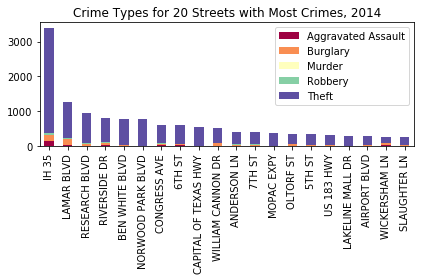

In [8]:
result_2014.sort_values('Sum', ascending=False).drop('Sum', 1)[:20].plot(kind='bar', 
                                                          stacked=True, 
                                                          title='Crime Types for 20 Streets with Most Crimes, 2014',
                                                          colormap='Spectral').set_xlabel("")
#savefig('2014_crime_types.png', dpi=400)

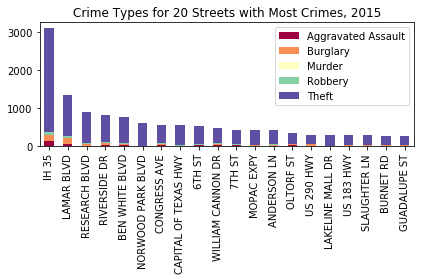

In [9]:
result_2015.sort_values('Sum', ascending=False).drop('Sum', 1)[:20].plot(kind='bar', 
                                                          stacked=True, 
                                                          title='Crime Types for 20 Streets with Most Crimes, 2015',
                                                          colormap='Spectral').set_xlabel("")
#savefig('2015_crime_types.png', dpi=400)

In [32]:
zipcode_counts = pd.DataFrame(crime['Zipcode'].value_counts())
zipcode_counts.columns = ['Sum']
zipcode_counts.head()

,Sum
78753,7407
78741,6367
78758,5389
78704,5286
78745,4999


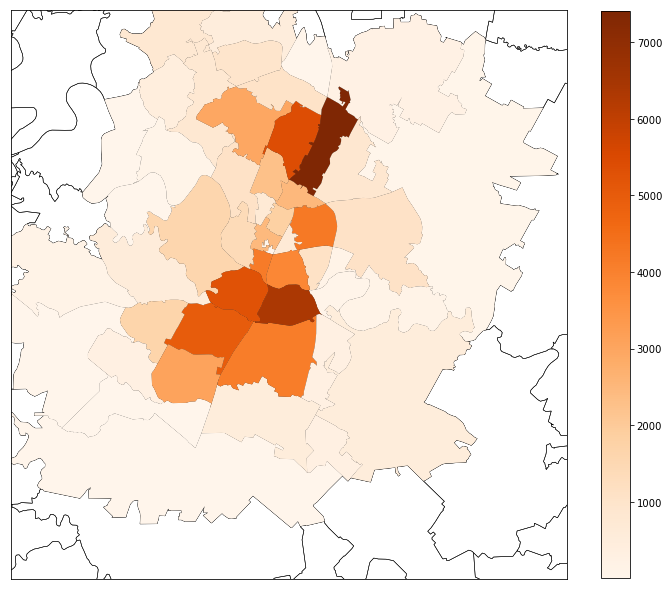

In [44]:
fig, ax = plt.subplots(figsize=(10,20))

austin_map = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            lat_0=30.2409175, lon_0=-97.708089,
            llcrnrlat=29.976577, llcrnrlon=-98.011817, 
            urcrnrlat=30.505258, urcrnrlon=-97.414361)

austin_map.readshapefile('data/Zipcodes', 'areas')

df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in austin_map.areas],
        'area': [area['ZCTA5CE10'] for area in austin_map.areas_info]
    })

df_poly = df_poly.merge(zipcode_counts, left_on='area', right_index=True, how='inner')

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(df_poly['Sum'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['Sum'])
plt.colorbar(mapper, shrink=0.4)

savefig('Total_crime_heatmap.png', dpi=600)